# Coastal Change

**Description: **

In [1]:
%matplotlib inline

from datetime import datetime

import datacube
import utils.data_cube_utilities.dc_utilities as utils

from utils.data_cube_utilities.dc_mosaic import create_mosaic, ls7_unpack_qa
from utils.data_cube_utilities.dc_water_classifier import *

import warnings; warnings.simplefilter('ignore')

In [2]:
start_time = datetime.now()
print("Start time: " + str(start_time))

Start time: 2018-04-20 09:58:58.969803


In [3]:
# Initialize data cube object
dc = datacube.Datacube(config='/home/localuser/.datacube.conf', app='dc-coastal-erosion')

# Set query parameters
platform        = 'LANDSAT_7'
product_type    = 'ls7_ledaps_togo'

min_lon         = 1.1919
max_lon         = 1.4509
min_lat         = 6.0809
max_lat         = 6.2218

In [4]:
start_date      = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date        = datetime.strptime('2000-12-31', '%Y-%m-%d')

In [5]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
# Retrieve data from Data Cube
dataset_in_2000 = dc.load(platform=platform,
                          product=product_type,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat), measurements=measurements)

In [6]:
start_date      = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date        = datetime.strptime('2015-12-31', '%Y-%m-%d')

In [7]:
# Retrieve data from Data Cube
dataset_in_2015 = dc.load(platform=platform,
                          product=product_type,
                          time=(start_date, end_date),
                          lon=(min_lon, max_lon),
                          lat=(min_lat, max_lat), measurements=measurements)

In [8]:
clear_xarray  = ls7_unpack_qa(dataset_in_2000.pixel_qa, "clear")  
water_xarray  = ls7_unpack_qa(dataset_in_2000.pixel_qa, "water")
clean_mask_2000 = np.logical_or(clear_xarray.values.astype(bool),
                           water_xarray.values.astype(bool))

clear_xarray  = ls7_unpack_qa(dataset_in_2015.pixel_qa, "clear")  
water_xarray  = ls7_unpack_qa(dataset_in_2015.pixel_qa, "water")
clean_mask_2015 = np.logical_or(clear_xarray.values.astype(bool),
                           water_xarray.values.astype(bool))

mosaic_2000 = create_mosaic(dataset_in_2000, clean_mask=clean_mask_2000)
mosaic_2015 = create_mosaic(dataset_in_2015, clean_mask=clean_mask_2015)

In [9]:
water_class_2000 = wofs_classify(mosaic_2000,
                                 mosaic=True,
                                 clean_mask=np.ones(mosaic_2000.red.shape).astype(np.bool))

water_class_2000.wofs.values[water_class_2000.wofs.values == -9999] = np.nan

water_class_2015 = wofs_classify(mosaic_2015, mosaic=True, clean_mask= np.ones(mosaic_2015.red.shape).astype(np.bool))
water_class_2015.wofs.values[water_class_2015.wofs.values == -9999] = np.nan

wofs_2000 = water_class_2000.wofs.values
wofs_2015 = water_class_2015.wofs.values

In [10]:
coastal_change = water_class_2015 - water_class_2000

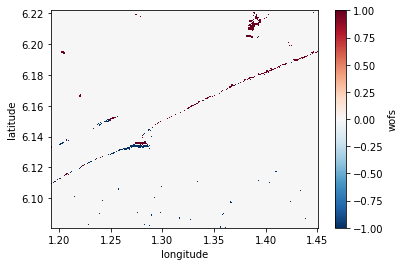

In [11]:
# -1 -> water to coast
#  0 -> no change
#  1 -> coast to water (Coastal Erosion)

coastal_change.wofs.plot()

In [12]:
coastline_2000 = np.zeros(wofs_2000.shape)

for i in range(wofs_2000.shape[0]):
    for j in range(wofs_2000.shape[1]):
        pixel = wofs_2000[i,j]
        if pixel == 0 and np.nansum(wofs_2000[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(wofs_2000[i-1:i+2, j-1:j+2]) <= 5:
            coastline_2000[i,j] = 1
            
coastline_2015 = np.zeros(wofs_2015.shape)

for i in range(wofs_2015.shape[0]):
    for j in range(wofs_2015.shape[1]):
        pixel = wofs_2015[i,j]
        if pixel == 0 and np.nansum(wofs_2015[i-1:i+2, j-1:j+2]) >= 1 and np.nansum(wofs_2015[i-1:i+2, j-1:j+2]) <= 5:
            coastline_2015[i,j] = 1

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [14]:
from pylab import *

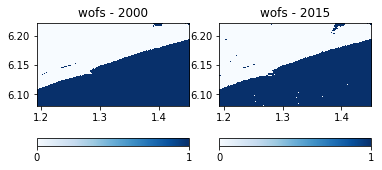

In [15]:
fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(wofs_2000, cmap='Blues',
                     extent=[water_class_2000.longitude.values.min(), 
                             water_class_2000.longitude.values.max(),
                             water_class_2000.latitude.values.min(),
                             water_class_2000.latitude.values.max()])
a.set_title('wofs - 2000')
plt.colorbar(ticks=[0,1], orientation ='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(wofs_2015, cmap='Blues',
                     extent=[water_class_2015.longitude.values.min(), 
                             water_class_2015.longitude.values.max(),
                             water_class_2015.latitude.values.min(),
                             water_class_2015.latitude.values.max()])
#imgplot.set_clim(0.0,1.0)
a.set_title('wofs - 2015')
plt.colorbar(ticks=[0,1], orientation='horizontal')
plt.savefig('wofs_compare.png')

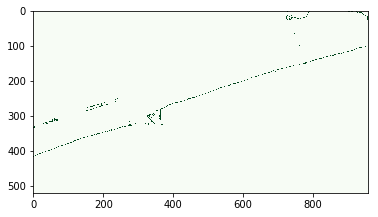

In [16]:
plt.imshow(coastline_2000, cmap='Greens')

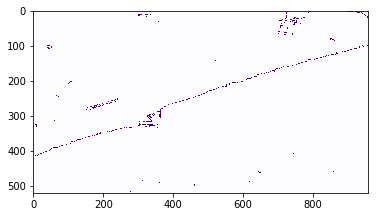

In [17]:
plt.imshow(coastline_2015, cmap='Purples')

In [18]:
mosaic_2000

<xarray.Dataset>
Dimensions:    (latitude: 520, longitude: 957)
Coordinates:
  * latitude   (latitude) float64 6.222 6.222 6.221 6.221 6.221 6.22 6.22 ...
  * longitude  (longitude) float64 1.192 1.192 1.192 1.193 1.193 1.193 1.193 ...
Data variables:
    red        (latitude, longitude) float32 1600.0 1532.0 1515.0 1910.0 ...
    green      (latitude, longitude) float32 1203.0 1146.0 1165.0 1492.0 ...
    blue       (latitude, longitude) float32 820.0 838.0 802.0 1014.0 943.0 ...
    nir        (latitude, longitude) float32 2650.0 2575.0 2650.0 2764.0 ...
    swir1      (latitude, longitude) float32 3541.0 3361.0 3384.0 3429.0 ...
    swir2      (latitude, longitude) float32 2827.0 2615.0 2615.0 2827.0 ...
    pixel_qa   (latitude, longitude) int32 66 66 66 66 66 66 66 66 66 66 66 ...

In [19]:
mosaic_rgb_2000 = np.array([mosaic_2000.red.values, mosaic_2000.green.values, mosaic_2000.blue.values])

In [20]:
mosaic_rgb_2000

array([[[1600., 1532., 1515., ...,  837.,  855.,  621.],
        [1566., 1497., 1636., ...,  873.,  855.,  682.],
        [1497., 1549., 1636., ...,  855.,  855.,  682.],
        ...,
        [ 413.,  373.,  433., ...,  398.,  378.,  398.],
        [ 413.,  393.,  393., ...,  418.,  398.,  378.],
        [ 413.,  393.,  393., ...,  418.,  358.,  378.]],

       [[1203., 1146., 1165., ...,  873.,  873.,  750.],
        [1146., 1165., 1183., ...,  893.,  893.,  750.],
        [1126., 1146., 1146., ...,  893.,  873.,  750.],
        ...,
        [ 514.,  514.,  492., ...,  498.,  520.,  475.],
        [ 492.,  492.,  492., ...,  498.,  475.,  475.],
        [ 537.,  492.,  492., ...,  498.,  475.,  453.]],

       [[ 820.,  838.,  802., ...,  732.,  750.,  729.],
        [ 802.,  786.,  786., ...,  732.,  750.,  729.],
        [ 786.,  802.,  802., ...,  750.,  750.,  709.],
        ...,
        [ 568.,  568.,  547., ...,  554.,  575.,  575.],
        [ 568.,  568.,  568., ...,  575.,  57